In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

[0.16266417009155662, 0.44103847913700805, 0.3962973507714354]


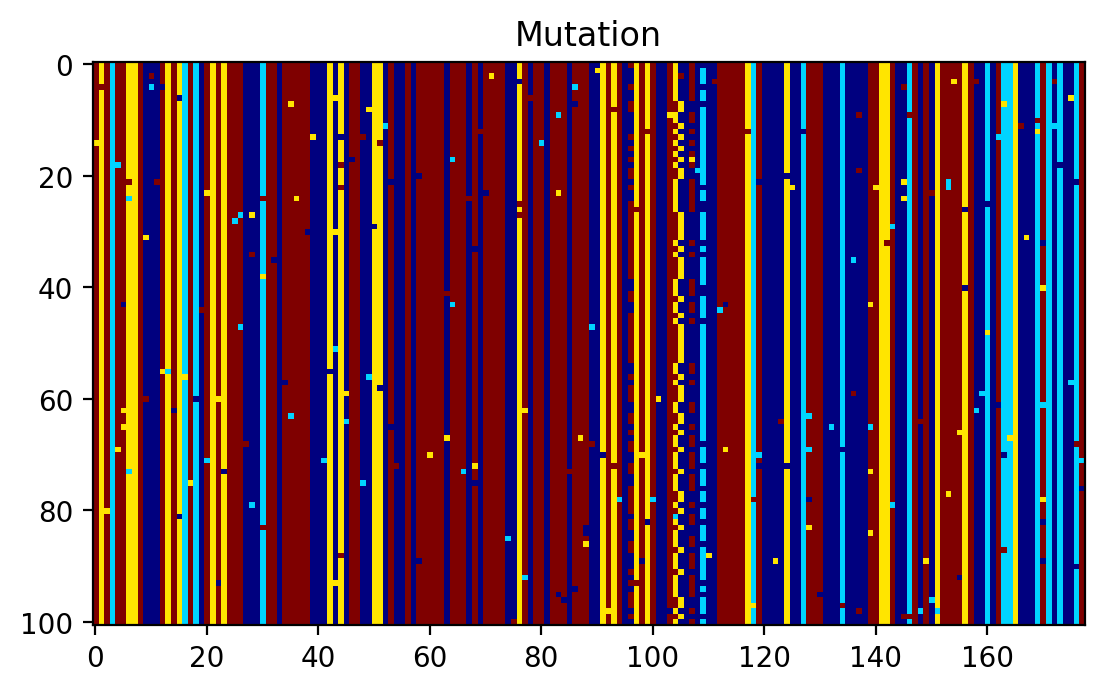

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10,100,0.01,0.01)
alignments_int = dg.char_to_int(alignments)
alignment_int = dg.char_to_int(alignments[0])
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignment_int,cmap='jet')
print(prob_lists[0])

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10,100,0.01,0.01)


In [ ]:
orgn = alignments[0]
print(len(orgn))

101


In [ ]:
print(len(alignments[0]))
alignments = [dg._array_dup(i,101) for i in alignments]
print(len(alignments))

101
10


In [ ]:
print(alignments[8].shape)
print(alignments[8])
alignments_int = dg.char_to_int(alignments)

(2, 101, 178)
[[['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]

 [['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]]


In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments_int.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments_int.shape[0]*0.8)
train_alignments, valid_alignments = alignments_int[idxs[:split_idx]], alignments_int[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(8, 2, 101, 178)
(8, 3)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 6, 5) # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(6, 16, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(720, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 3) # Defines how many classes of outputs - 2 = yes/no; 3 = hom-ref, hom-nref, het
        #self.softmax = torch.nn.Softmax(dim=3) # We add a softmax layer to compute the final output

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        return x


In [ ]:
def train(model, train_alignments, train_mutation_types, valid_alignments, valid_mutation_types, epochs=10, lr=0.001):
    crit = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_alignments).float(), torch.tensor(train_mutation_types))
    valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(valid_alignments).float(), torch.tensor(valid_mutation_types))

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=16)

    train_losses, valid_losses, valid_accs = [], [], []

    for epoch in range(1, epochs + 1):
        # train for 1 epoch
        model = model.train()
        epoch_loss, total = 0.0, 0
        for i, (batch_alignment, batch_mutation_type) in enumerate(train_loader):
            opt.zero_grad()
            out = model(batch_alignment)
            loss = crit(out, batch_mutation_type)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss /= total

        # compute validation loss and accuracy
        model = model.eval()
        valid_loss, n_correct, n, total = 0.0, 0, 0, 0
        for i, (batch_alignment, batch_mutation_type) in enumerate(valid_loader):
            with torch.no_grad():
                out = model(batch_alignment)
                loss = crit(out, batch_mutation_type)

            valid_loss += loss.item()
            total += 1

            predict = torch.nn.functional.softmax(out, dim=1).argmax(dim=1)
            correct = predict == batch_mutation_type
            n += out.shape[0]
            n_correct += correct.sum()
        valid_loss /= total
        accuracy = n_correct / n

        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(accuracy)
        print(f"epoch={epoch:2d}, train_loss={epoch_loss:.3f}, valid_loss={valid_loss:.3f}, accuracy={accuracy*100:.2f}%")

    return train_losses, valid_losses, valid_accs

In [ ]:
model = CNN()
n_epochs = 15 # number of epochs
lr = 0.001 # learning rate

In [ ]:
print(train_alignments.shape)

(8, 2, 101, 178)


In [ ]:
train_losses, valid_losses, valid_accs = train(model, train_alignments, train_prob_lists, valid_alignments, valid_prob_lists, epochs=n_epochs, lr=lr)


RuntimeError: ignored